## WORKFLOW --- EXPORT ALL POLYGONS

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# to work with rasters
# https://rasterio.readthedocs.io/en/latest/quickstart.html#opening-a-dataset-in-reading-mode
import rasterio
from rasterio.plot import show
from rasterio.features import shapes

from shapely.geometry import Polygon
from shapely.affinity  import affine_transform
import geopandas as gpd

In [2]:
### ***** FUNCTIONS TO THICKEN PIXELS *****

# ------------------------------------------------------------------

def thicken_pixel(raster, i_cent,j_cent, d):
    
    i_0 = int(i_cent - ((d-1)/2))
    j_0 = int(j_cent - ((d-1)/2))

    for x in range(i_0,i_0+d):
        for y in range(j_0,j_0+d):
            if(-1<x<raster.shape[0] and -1<y<raster.shape[1]):
                if(raster[x,y] != 1):
                    raster[x,y] = 1
    return 
# ------------------------------------------------------------------

def thicken_pixels(raster,d):
    m = raster.shape[0]
    n = raster.shape[1]
    
    new_rast = np.zeros((m,n))
    
    for i in range(0,m):
        for j in range(0,n):
            if(raster[i,j] == 1):
                thicken_pixel(new_rast,i,j,d)
                
    return new_rast

In [6]:
# *** EXTRACT POLYGONS FROM REGIONS ***

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from shapes function
#({'type': 'Polygon', 'coordinates': [[(6.0, 0.0), (6.0, 2.0), (8.0, 2.0), (8.0, 0.0), (6.0, 0.0)]]}, 1.0)
# def create_polygon(shape):
    
#     poly_list = shape.get('coordinates')

#     if len(poly_list) == 1:    # polygon without holes
#         return(Polygon(poly_list[0]))

#     holes = []
#     for i in range(1,len(poly_list)):
#         holes.append(poly_list[i])
#     return(Polygon(shell=poly_list[0], holes=holes))

# # ------------------------------------------------------------------
# # shapes list is output from rasterio.features.shapes 
# # obtain crs and affine transf from raster
# def shapes_2_gpddf(shapes_list, raster):
    
#     coords = []
#     for shape, value in shapes_list:
#         coords.append(shape)
    
#     polys = []
#     for i in range(0,len(coords)):
#         polys.append(create_polygon(coords[i]))
        
#     aff_trans = [raster.transform[0], raster.transform[1], raster.transform[3], 
#                  raster.transform[4], raster.transform[2], raster.transform[5]]
#     aff_data = gpd.GeoDataFrame()
    
#     for i in range(0,len(polys)):  # **** CHECK WHAT HAPPENS WITH LAST POLYGON ****
#         aff_data.loc[i,'geometry'] = affine_transform(polys[i],aff_trans)
    
#     aff_data.crs = raster.crs
    
#     return(aff_data)
    

In [6]:
# *** EXTRACT POLYGONS FROM REGIONS ***

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from shapes function
#({'type': 'Polygon', 'coordinates': [[(6.0, 0.0), (6.0, 2.0), (8.0, 2.0), (8.0, 0.0), (6.0, 0.0)]]}, 1.0)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return(Polygon(poly_list[0]))

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------
# shapes list is output from rasterio.features.shapes 
# obtain crs and affine transf from raster
def shapes_2_gpddf(shapes_list, crs = False):
    
#     if( ((crs and affine) == True) and (raster == False)):
#         raise Excepetion()
    
    polys = []
    for shape, value in shapes_list:
        polys.append(create_polygon(shape))
    
    aff_trans = [raster.transform[0], raster.transform[1], raster.transform[3], 
                 raster.transform[4], raster.transform[2], raster.transform[5]]
    aff_data = gpd.GeoDataFrame()
    
    for i in range(0,len(polys)): 
        aff_data.loc[i,'geometry'] = affine_transform(polys[i],aff_trans)
    
    aff_data.crs = raster.crs
    
    return aff_data
    

## EXMAPLE

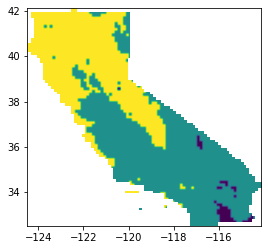

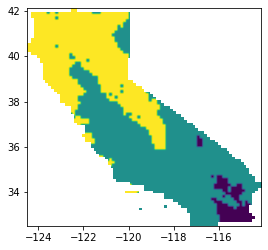

<AxesSubplot:>

In [3]:
arid8 = rasterio.open('arid_regions_2008.tif')
arid19 = rasterio.open('arid_regions_2019.tif')

#show(arid8)
#show(arid19)

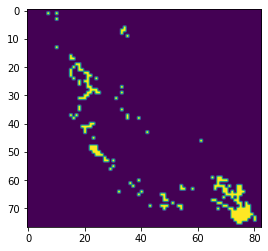

<AxesSubplot:>

In [4]:
# desert = 1
# dry = 2
# moist = 3

more_arid = arid8.read(1) -  arid19.read(1)
more_arid = np.where(more_arid<1,0,more_arid) 
more_arid = np.where(more_arid>0,1,more_arid)
show(more_arid)

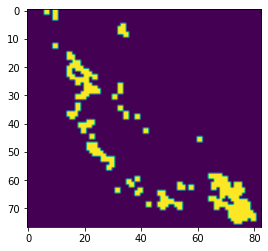

<AxesSubplot:>

In [5]:
thick_regions = thicken_pixels(more_arid,2)
# shapes function only takes certain int types (see documentation)
# since raster is binary, we're using the smalest type
thick_regions = thick_regions.astype('unit8')  
show(thick_regions)

In [18]:
thick_shps = shapes(thick_regions, connectivity = 8)
aff_data = shapes_2_gpddf(thick_shps , arid8)
#aff_data

In [19]:
# Create an output path for the data
outfp = "/home/jovyan/outlining_regions/trial_polygons2.shp"
aff_data.to_file(outfp)

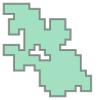

In [11]:

aff_data.loc[22,'geometry']

In [ ]:
# no hole polygon
geoms[0].get('coordinates')

# polygon with a hole
geoms[22].get('coordinates')

In [16]:
new = gpd.GeoDataFrame()
new.loc[0,'geometry']= aff_data.loc[22,'geometry']
new.crs = arid8.crs

In [17]:
outfp = "/home/jovyan/outlining_regions/trial_polygons.shp"
new.to_file(outfp)